# Convolution & Smoothing

In this notebook, we will review the operation of *convolution*, and how it is used to model the hemodynamic response function in fMRI. We will also show how convolution with a Gaussian kernel smooths data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Inline plots
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
# A little config for image plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'equal'

# Hemodynamic response function!
The equation for the HRF given in Boynton et al 1996 is:

# $h(t) = \frac{(t/\tau)^{n-1}e^{-t/\tau}}{\tau(n-1)!}$

$t$ is time

$\tau$ is time constant, which governs the width of the function

$n$ governs the delay in the response, and must be an integer

> Put this into python!

In [2]:
# Fill me in!
from scipy.special import factorial

def gammafun(t, tau, n):
    """Computes gamma function for values in t"""
    num = (t/tau)**(n-1) * np.e**(-t/tau) # numerator of function above
    denom = tau * factorial(n-1) # denominator of function above
    return num/denom

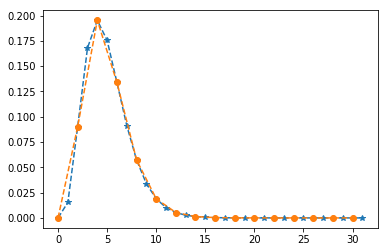

In [11]:
t = np.arange(32) 
t2 = np.arange(0, 32, 2) 
tau = 1
n = 5
y = gammafun(t, tau, n)
y2 = gammafun(t2, tau, n)
plt.plot(t, y, marker='*', ls='--');
plt.plot(t2, y2, marker='o', ls='--');

In [12]:
# Answer
from scipy.special import factorial

def gammafun(t, tau, n):
    num = (t/tau)**(n-1) * np.e**(-t/tau)
    denom = tau*factorial(n-1)
    return num/denom

## BELOW HERE IS JUST FOR FANCY PLOTTING ##

from ipywidgets import widgets, interactive

def gamma_plot(tau, n):
    fig, ax = plt.subplots(num=33, figsize=(6,4))
    # What might happen with different sampling of T here?
    t = np.linspace(0, 32, 33) # 32 seconds worth
    #t = np.linspace(0, 32, 100) # 32 seconds worth
    # Note that there is a fudge here to make the units of n more sensible! 
    # (adding one to it makes n reflect the number of seconds to the peak
    # of the function, when tau = 1)
    ax.plot(t, gammafun(t, tau, n+1), '.-')
    ax.set_ylim(-0.01, 0.50)
    ax.set_xlabel('Time (s)')
    ax.grid(which='both')
    plt.show()

tau = widgets.FloatSlider(
    value=1,
    min=0,
    max=2.0,
    step=0.1,
    description='$\\tau$',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)

n = widgets.IntSlider(
    value=6,
    min=2,
    max=20,
    step=1,
    description='n',
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',)

interactive_plot = interactive(gamma_plot, tau=tau, n=n)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='$\\tau$', max=2.0, readout_format='.1f'), IntSlider(value=6, description='n', max=20, min=2), Output()), _dom_classes=('widget-interact',))

NOTE that this mathematical approximation of this HRF is NOT necessarily set in stone - there is no ground truth that says the HRF is and always should be a gamma function. This is a good-enough approximation (there are others out there that some say are slightly better). There is a large literature about estimating HRF parameters (as parameters of a gamma function and otherwise). One clear indicator of the kloodgy nature of the gamma function as an approximation of the HRF is that derivatives of the gamma function are often used along with it. 

The next cells show that you can create slightly different shapes of the HRF by fixing a gamma function and then adding a scaled version of the function's derivative back to it.

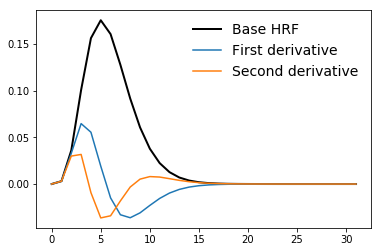

In [13]:
t = np.arange(32)
g = gammafun(t, tau=1, n=6)
# You may ask yourself, What does np.diff do on the next line? 
# Perhaps create a new cell and use the help: np.diff?
dg = np.hstack([0, np.diff(g)]) 
ddg = np.hstack([0, np.diff(dg)])
plt.plot(g, 'k', lw=2, label='Base HRF')
plt.plot(dg, label='First derivative')
plt.plot(ddg, label='Second derivative')
plt.legend(frameon=False, fontsize=14);

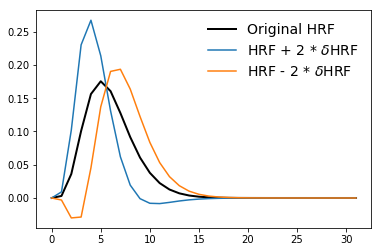

In [14]:
plt.plot(g, 'k-', lw=2, label='Original HRF')
plt.plot(g + 2 * dg, label='HRF + 2 * $\delta$HRF')
plt.plot(g - 2 * dg, label='HRF - 2 * $\delta$HRF')
plt.legend(frameon=False, fontsize=14);

# Convolve the HRF with a stimulus!

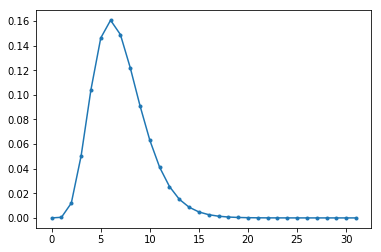

In [15]:
# Generate a canonical HRF
t = np.arange(32) # 32 seconds @TR = 1 second
hrf = gammafun(t, tau=1, n=6+1)

plt.plot(t, hrf, '.-');

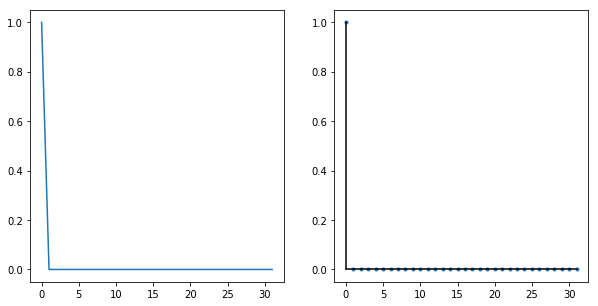

In [16]:
# Plot a single discrete stimulus that appears at time 0
stimulus = np.zeros(t.shape)
stimulus[0] = 1

plt.figure(1, figsize=(10, 5))
plt.subplot(121)
plt.plot(t, stimulus)

# There is a better function that we can use to make this plot more explicit
plt.subplot(122)
plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label='Stimulus');

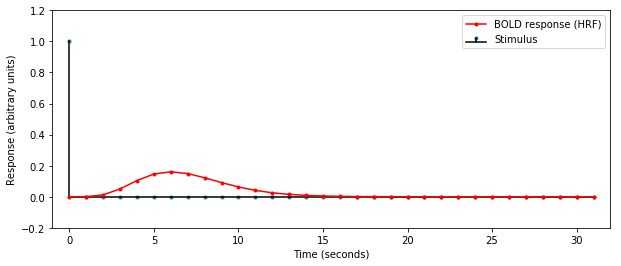

In [17]:
# We will be plotting stimulus / response pairs several times
# Hence, here is a function that can plot these two together
def stim_resp_plot(t, stimulus, response, yl=(-0.2, 1.2), label_stim='Stimulus', label_resp='BOLD response (HRF)'):
    """Plot stimulus and response."""
    plt.figure(figsize=(10,4))
    plt.stem(t, stimulus, linefmt='k-', markerfmt='.', basefmt='k-', label=label_stim)
    plt.plot(t, response, 'r.-', label=label_resp)
    plt.ylim(yl)
    plt.xlim([-1,t.max()+1])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Response (arbitrary units)')
    _ = plt.legend()

# Plot
stim_resp_plot(t, stimulus, hrf)

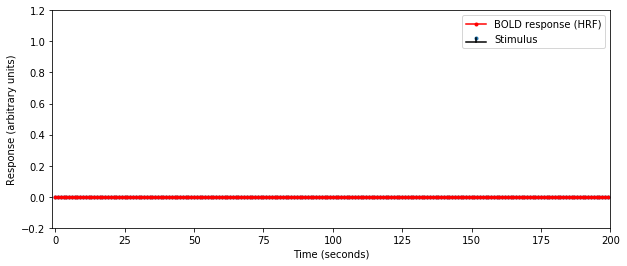

In [18]:
n = 200 # Total time points (TRs)
t = np.arange(n,)

# No stimulus
stimuli = np.zeros((n))

# We assume no response
response = np.zeros((n))

# Here we plot the function
stim_resp_plot(t, stimuli, response, yl=(-0.2, 1.2))

## Exercise 1

A few cells above we plotted how the signal changes when we have a stimulus at time 0. 

Now, imagine we have a stimulus at time `i=10`. What do you expect will happen when we plot the stimulus and response?

Hint: This stimulus will create an HRF that will be *added* to the signal from times i to times i + hrf_length (hrf_length is the length of our canonical HRF, which was 32 above).

Attention: Make sure you modify the response by adding something to its values, and not only changing it.

In [25]:
len(hrf)

32

In [26]:
len(stimuli)

200

In [31]:
i = 10
response[i:i+len(hrf)] = response[i:i+len(hrf)] + hrf

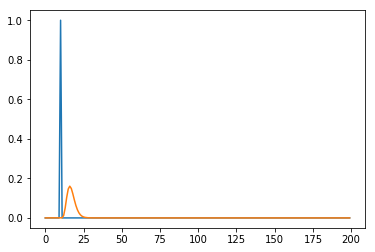

In [32]:
stimuli[i] = 1
plt.plot(stimuli)

plt.plot(response)

## Exercise 2


Now let's say that there were 3 event onsets, one at `i=10`, one at `i=70` and one at `i=150`, plot the resulting activity. 

In [40]:
a = 3
a += 2
a

5

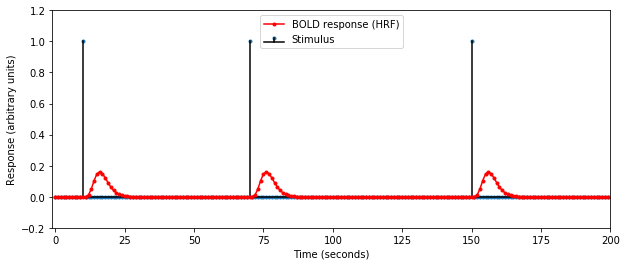

In [35]:
# Re-define stimuli, response
stimuli = np.zeros((n))
response = np.zeros((n))
# Loop over indices
for i in [10, 70, 150]:
    stimuli[i] = 1
    response[i:i+len(hrf)] += hrf
# Fancy plot
stim_resp_plot(t, stimuli, response)

## Exercise 3

Now say that the stimuli are closer together than the length of the hemodynamic function: let's say they occur at times 10, 21, 25, 70, 71,74, 75, 80 and 150, what happens? 

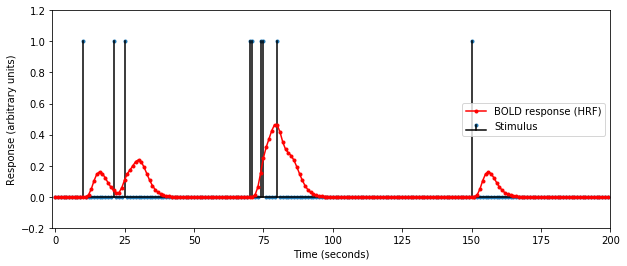

In [49]:
# Re-define stimuli, response
stimuli = np.zeros((n))
response = np.zeros((n))
# Loop over indices
for i in [10, 21, 25, 70, 71,74, 75, 80, 150]:
    stimuli[i] = 1
for i in np.arange(len(stimuli)):
    response[i:i+len(hrf)] += hrf[:len(stimuli)-i] * stimuli[i]
# Fancy plot
stim_resp_plot(t, stimuli, response)

Using python convolution function instead of rolling our own:

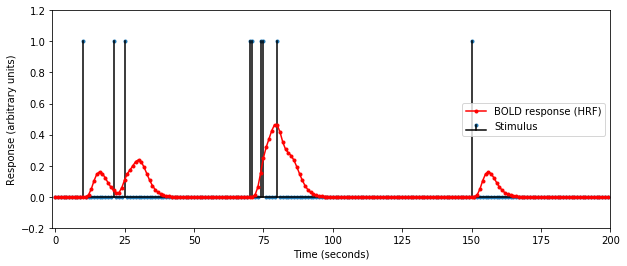

In [52]:
# We can use np.convolve to do effectively this same thing.
rr = np.convolve(stimuli, hrf, mode='full')
# rr is longer than stimuli by the length of the hrf, so we must crop it: 
#print(len(rr))
rr = rr[:len(stimuli)]
stim_resp_plot(t, stimuli, rr)

Note: using functions for convolution gets trickier, because you have to pay attention to edge effects, and how you want the convolution kernel to be centered on your data. For example, for the HRF, you want the full function to occur AFTER stimulus onset. However, if you want to smooth your data, you may want the peak of the convolution kernel to be centered on each point.

**Blackboard chat...**

# General case of 1D smoothing

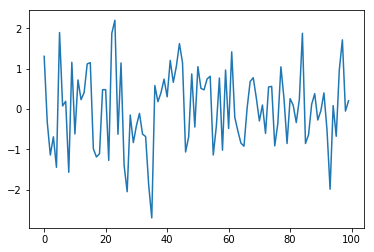

In [53]:
# Generate some noise data
n_timepoints = 100
data = np.random.randn(n_timepoints,)
fig, ax = plt.subplots()
_ = ax.plot(data)

In [55]:
x = np.linspace(-3, 3, n_c)
x

array([-3.        , -2.57142857, -2.14285714, -1.71428571, -1.28571429,
       -0.85714286, -0.42857143,  0.        ,  0.42857143,  0.85714286,
        1.28571429,  1.71428571,  2.14285714,  2.57142857,  3.        ])

1.0


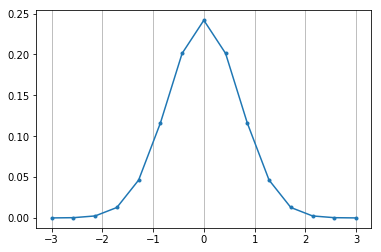

In [56]:
# Generate a gaussian smoothing kernel
n_c = 15
n_ = np.floor(n_c/2).astype(np.int)
# Range over which we will compute Gaussian
x = np.linspace(-3, 3, n_c)
# Simple Gaussian equation
g = np.e**(-x**2)
# To not change the amplitude of the response, the SUM of a smoothing kernel should equal 1!
g /= np.sum(g)
print(np.sum(g))
plt.plot(x,g, '.-')
plt.grid(axis='x')

# 1D convolution

In [57]:
# Help!
np.convolve?

True
(100,)


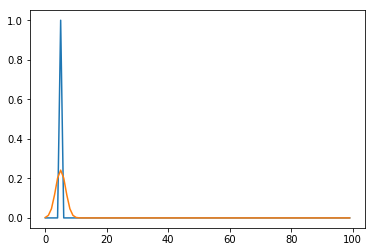

In [58]:
# Simple case
s = np.zeros((100,))
s[5] = 1
s_c = np.convolve(s, g, mode='same')
s_c2 = np.convolve(s, g, mode='full')
s_c2 = s_c2[n_:-n_]
print(np.allclose(s_c2, s_c))
print(s_c.shape)
plt.plot(s);
plt.plot(s_c);

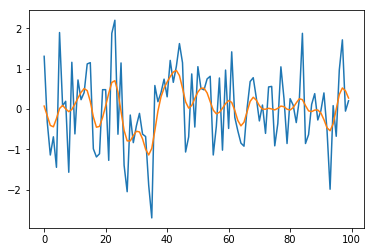

In [59]:
data_c = np.convolve(data, g, mode='full')
n_ = np.floor(n_c/2).astype(np.int)
data_c = data_c[n_:-n_]
plt.plot(data, label='original')
plt.plot(data_c, label='smoothed')

## Exercise 4
Create a filter to take a block average rather than a Gaussian kernel. Test it on some simple data (e.g., convolve it with `s` created above), then convolve it with the data above)

# Convolution w/ Gaussian kernel (smoothing) in 2D data

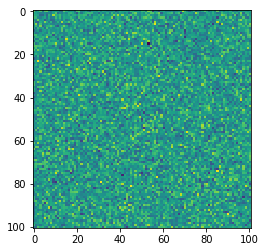

In [60]:
dims = [101, 101]
data2d = np.random.randn(*dims)
plt.imshow(data2d);

## Exercise 5
Create a 2D Gaussian kernel! The equation for a 2D Gaussian is:

# $g = e^{-\frac{(x-\mu_x)^2}{2\sigma^2_x} + \frac{(y-\mu_y)^2}{2\sigma^2_y}}$

$\sigma_x$ is the standard deviation of the Gaussian in the x dimension

$\sigma_y$ is the standard deviation of the Gaussian in the y dimension

Critical to this endeavor is defining the X and Y over which the function will be evaluated. To do that, you need a *grid* of values (arrays of x and y values that vary linearly in the x and y dimensions). To create such a grid, use `np.meshgrid`, as follows:

In [61]:
# (Hint / help cell)
kernel_size = 7 # pixels
xyrange = np.linspace(-3, 3, kernel_size)
x, y = np.meshgrid(xyrange, xyrange)
print('x:')
print(x)
print('y:')
print(y)
# This x and y should go into the computation of your 2D Gaussian!

x:
[[-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]]
y:
[[-3. -3. -3. -3. -3. -3. -3.]
 [-2. -2. -2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.]]


In [ ]:
# Fill me in!
g = np.exp(x+y) #...

# (better still, make this a function that takes inputs mu_x, mu_y, sigma_x, sigma_y...)
def make_gauss(x, y, mu_x, mu_y, sigma_x, sigma_y):
    g = 0 #...
    return g

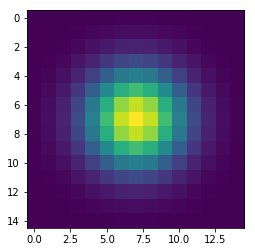

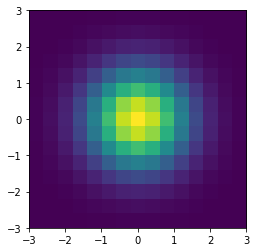

In [62]:
# Answer
# 2D gaussian kernel
n_c = 15
t = np.linspace(-3, 3, n_c)
x, y = np.meshgrid(t, t)
def make_gauss(x, y, mu_x, mu_y, sigma_x, sigma_y):
    g = np.e**(-((x-mu_x)**2/(2*sigma_x**2) + (y-mu_y)**2/(2*sigma_y**2)))
    return g / np.sum(g)
g2d = make_gauss(x, y, 0, 0, 1, 1)
plt.imshow(g2d);
# Or try this (to show the x, y range over which this function was actually evaluated) : 
plt.figure()
plt.imshow(g2d, extent=(-3, 3, -3, 3));
# Note: there is another function called plt.pcolormesh() that explicity takes x and y values.
# look into it if you are curious.

To smooth the image, convolve this kernel with the image, using a convolve2d function! The principle is approximately the same as with the 1D case, but now the filter acts over two dimensions.

In [63]:
# Not in the same library, because python.
from scipy.signal import convolve2d

(101, 101)


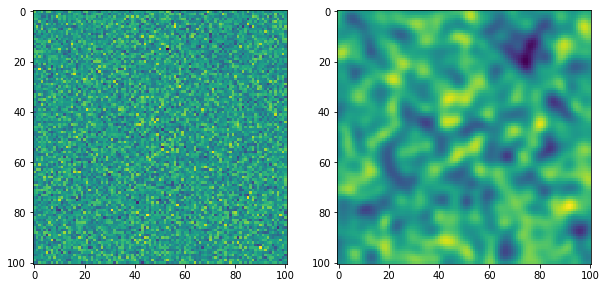

In [64]:
data2d_c = convolve2d(data2d, g2d, mode='full')
n_ = np.floor(n_c/2).astype(np.int)
data2d_c = data2d_c[n_:-n_, n_:-n_]
print(data2d_c.shape)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(data2d);
axs[1].imshow(data2d_c);

In [66]:
from skimage import data

In [67]:
image = data.coins()
image_c = convolve2d(image, g2d, mode='same')

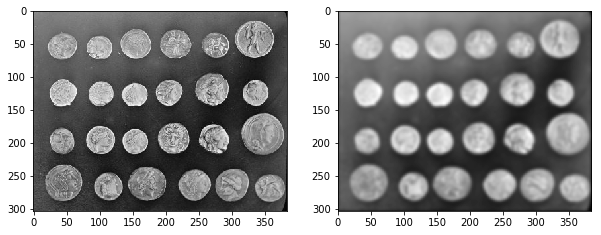

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(image, cmap='gray')
ax2.imshow(image_c, cmap='gray')

## Exercise 6
Make it blurrier! How would you blur out more of the coins? DO IT.

# Smoothing can reveal real signal hidden in noisy data

In [ ]:
data2d_noisy = np.random.randn(*dims)
data2d_noisy[10:30,10:30] += 0.6
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(data2d_noisy)
data2d_noisy_c = convolve2d(data2d_noisy, g2d, mode='same')
axs[1].imshow(data2d_noisy_c)

... But also can obscure potentially real variation at a scale smaller than the smoothing kernel!

## Exercise

Create a design matrix as we did last week, and convolve each column of X with the boynton HRF! Use THAT X to generate data (plus some noise) (This is how the fMRI signal is modeled in the Boynton paper!)

In [ ]:
X = ...
B = ...
# Convolve X with the HRF function
Xc = np.convolve()
E = ...
Y = X.dot(B) + E

## Exercise 
Estimate $\beta$ from your simulated data using the regression equation from last week. 

Play with the noise level until your estimated $\beta$ weights become inaccurate!

## Advanced exercise

See if you can create a design matrix that will NOT allow you to accurately estimate B weights!